# Graph Theoretical Analysis

In [1]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import SigProc
from analysis.resampling import Resampler
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM2_drd87.csv
3. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
4. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
5. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
6. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
7. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
8. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [4]:
drd87_data = pd.read_csv(raw_files[2], header=None)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd87_data, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[0], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Only leave the neuron numbers to save space when plotting the networks
drd87_fe.cell_transients_df.columns = [i for i in range(1, len(drd87_fe.cell_transients_df.columns)+1)]

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [5]:
def get_neuron_positions(neuron_network, coordinates_df):
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

In [6]:
coordinates = pd.read_csv("/Users/saveliyyusufov/Hen_Lab/Mice/DRD87_NO_OFT_POPP_reg/EPM_NO_OFT_POPP_centroids.csv" ,header=None)
coordinates.columns = ['x', 'y']

# Reset the index so that it starts from 1, since we refer to neurons as neurons 1, 2, ..., n
coordinates.index = pd.RangeIndex(1, len(coordinates.index)+1)

## In complex networks, the degree distributions are non-Gaussian, and often have a long tail towards high degrees (Bullmore et al. 2009)
## So, we plot the network of neurons for `drd87` when it was in the open arms, and we follow it up with the degree distribution of the neuronal network in the open arms. We do the same for `drd87` in the closed arms.

#### **Note**: "Some networks (including the Internet and the World Wide Web) have degree distributions in the form of a power law: that is, the probability that a node has degree $k$ is given as $Prob(k)$ ~ $k – \lambda$. In biological systems, the degree exponent $\lambda$ often ranges between $2$ and $3$, and the very gradual (‘heavy-tail’) power law decay of the degree distribution implies that the network lacks a characteristic scale — hence such networks are called ‘scale-free’ networks. Barabási and Albert demonstrated that scale-free networks can originate from a process by which each node that is added to the network as it grows connects preferentially to other nodes that already have high degree. Scale-free networks are unlikely if the attachment of connections is subject to physical constraints or associated with a cost. Therefore, physically embedded networks, in which nodes have limited capacity for making connections, often do not have pure power law degree distributions but may instead demonstrate exponentially truncated power law degree distributions, which are associated with a lower probability of very high degree nodes." (Bullmore et. al 2009)



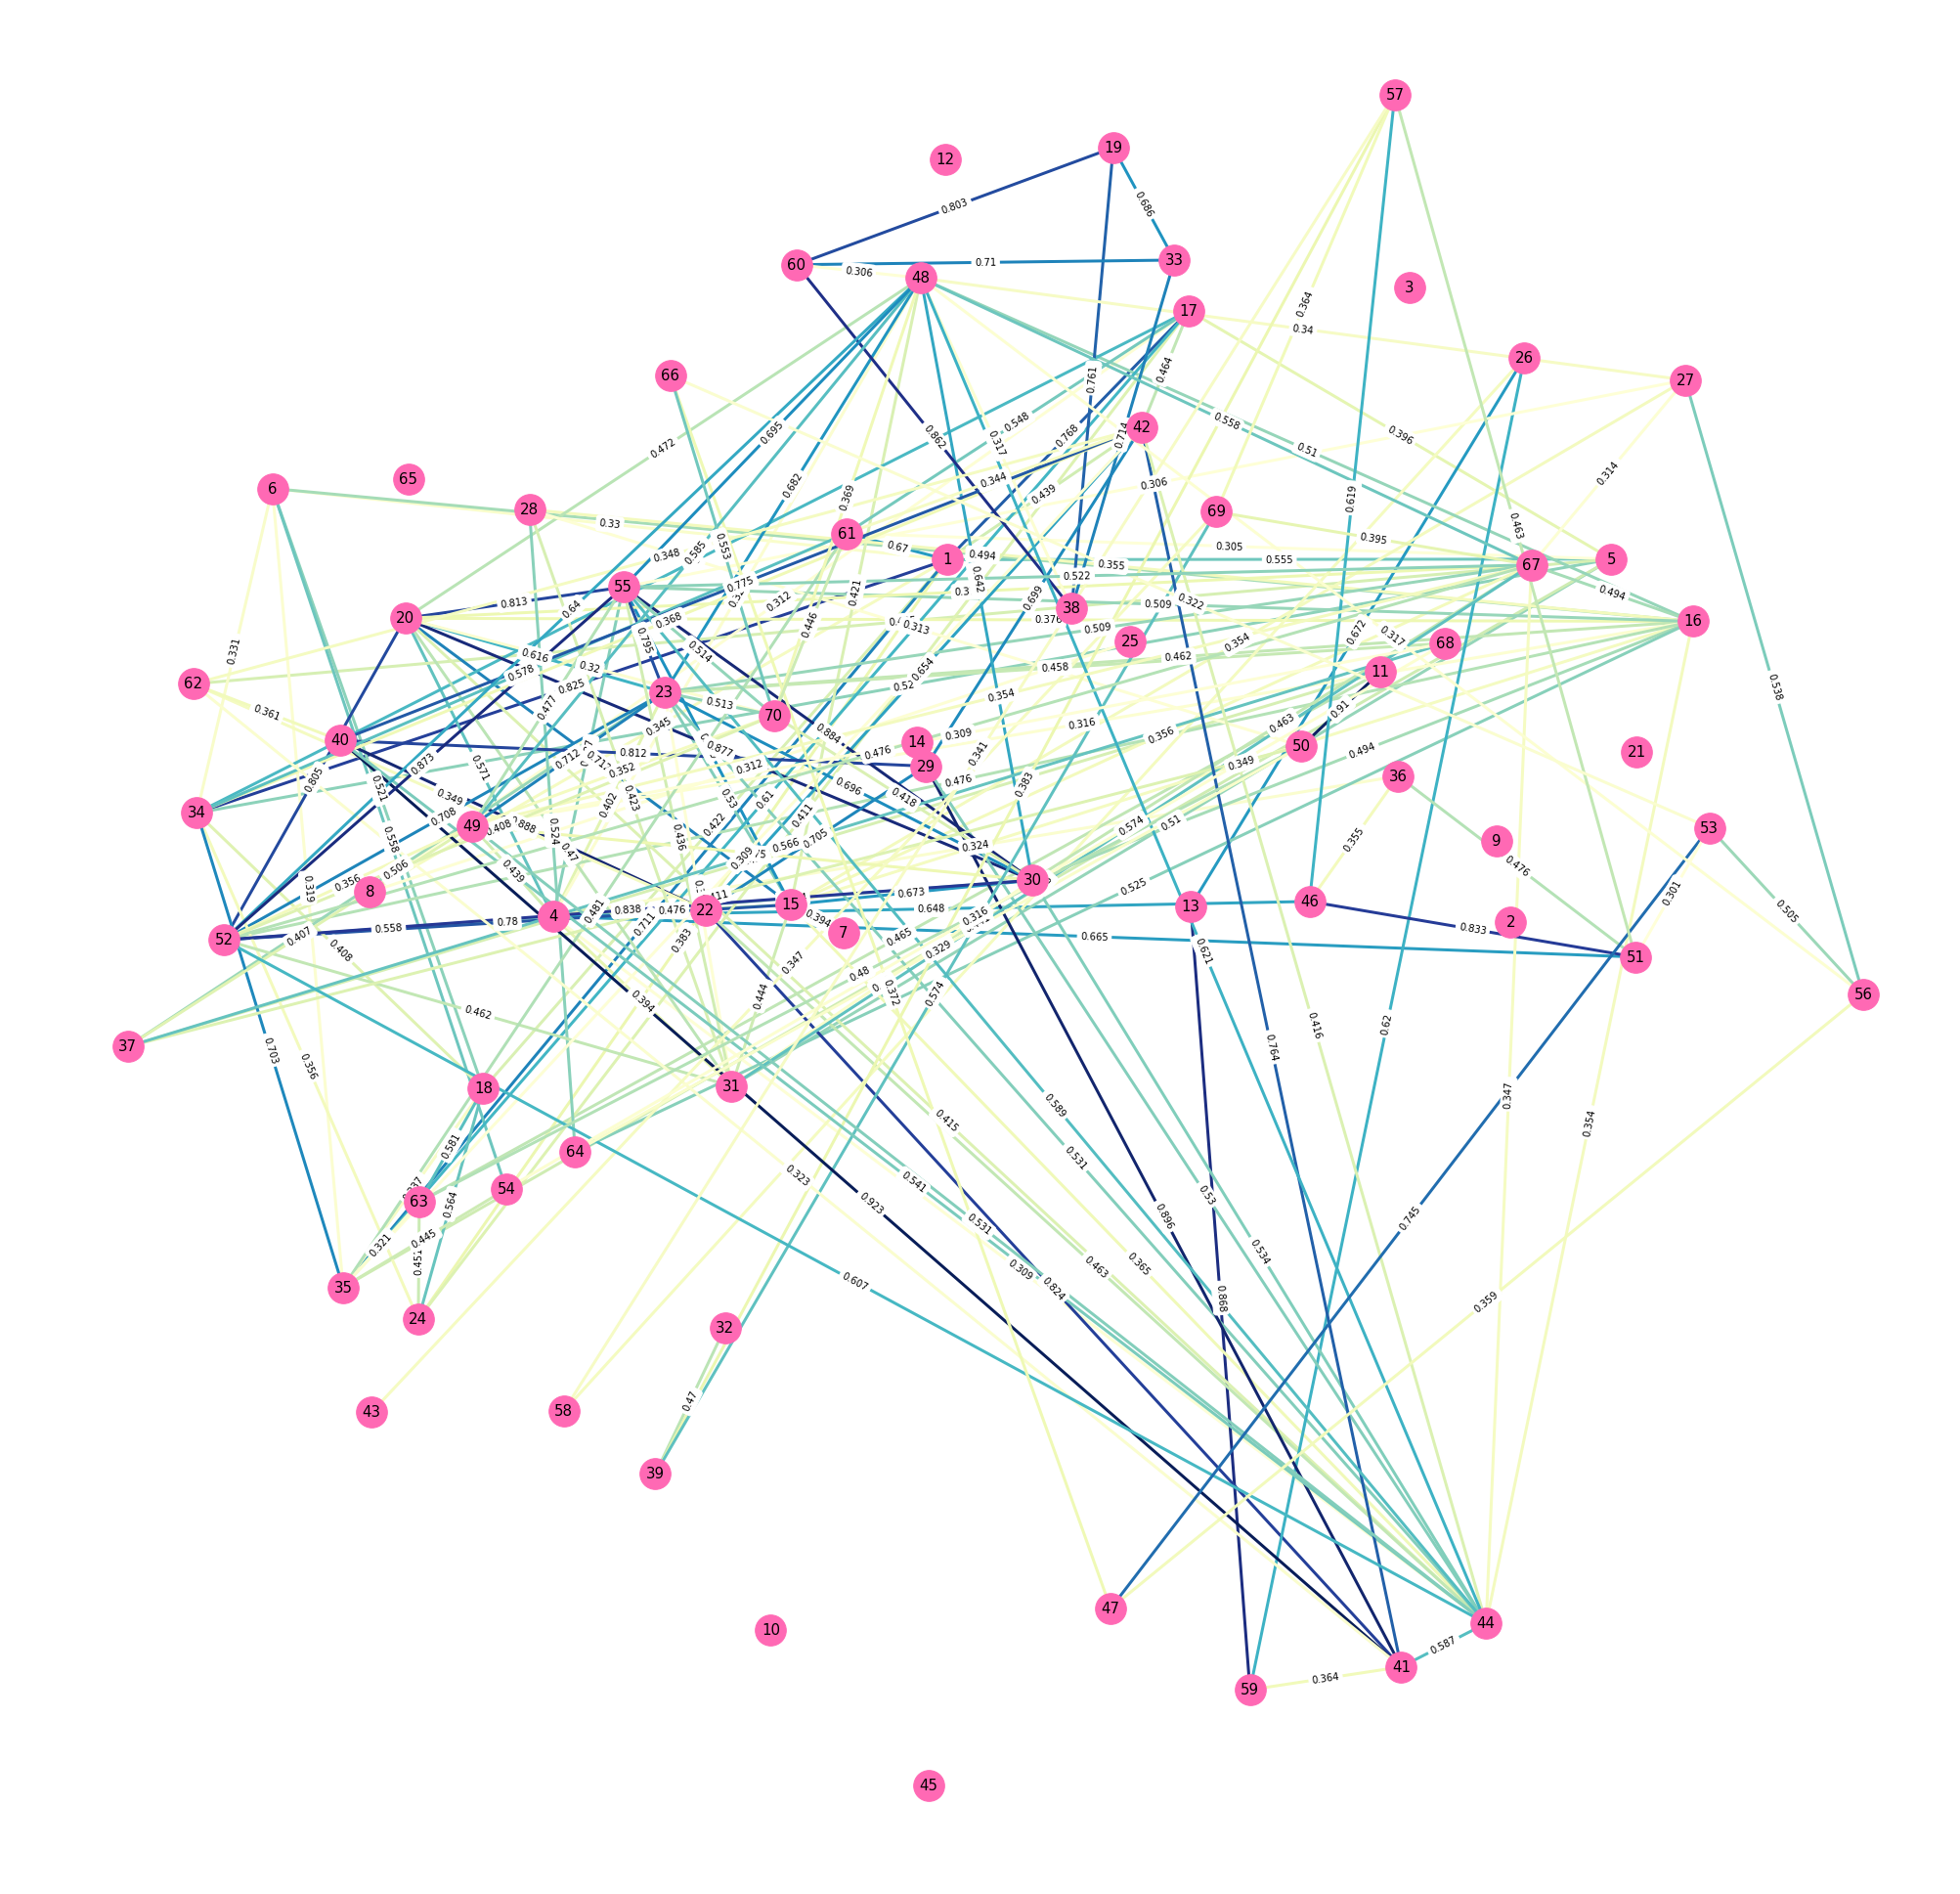

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



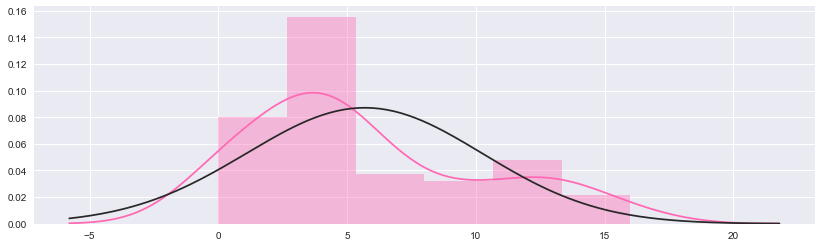

In [7]:
indices = drd87_fe.neuron_concated_behavior.loc[drd87_fe.neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
drd87_open_arms_graph = NeuronNetwork(drd87_fe.cell_transients_df.iloc[indices])
pos = get_neuron_positions(drd87_open_arms_graph, coordinates)

drd87_open_arms_graph.plot(pos=pos, figsize=(35,35), node_color="hotpink", node_size=1000, save=False, file_name="drd87_open_arms_graph.png")
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(drd87_open_arms_graph.network.degree()).values()), color='hotpink', fit=stats.loggamma);

## Bar plot of node degree in the **Open Arms**

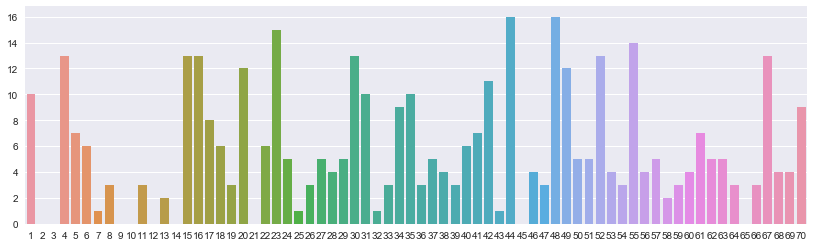

In [8]:
sns.barplot(x=list(dict(drd87_open_arms_graph.network.degree()).keys()), y=list(dict(drd87_open_arms_graph.network.degree()).values()));

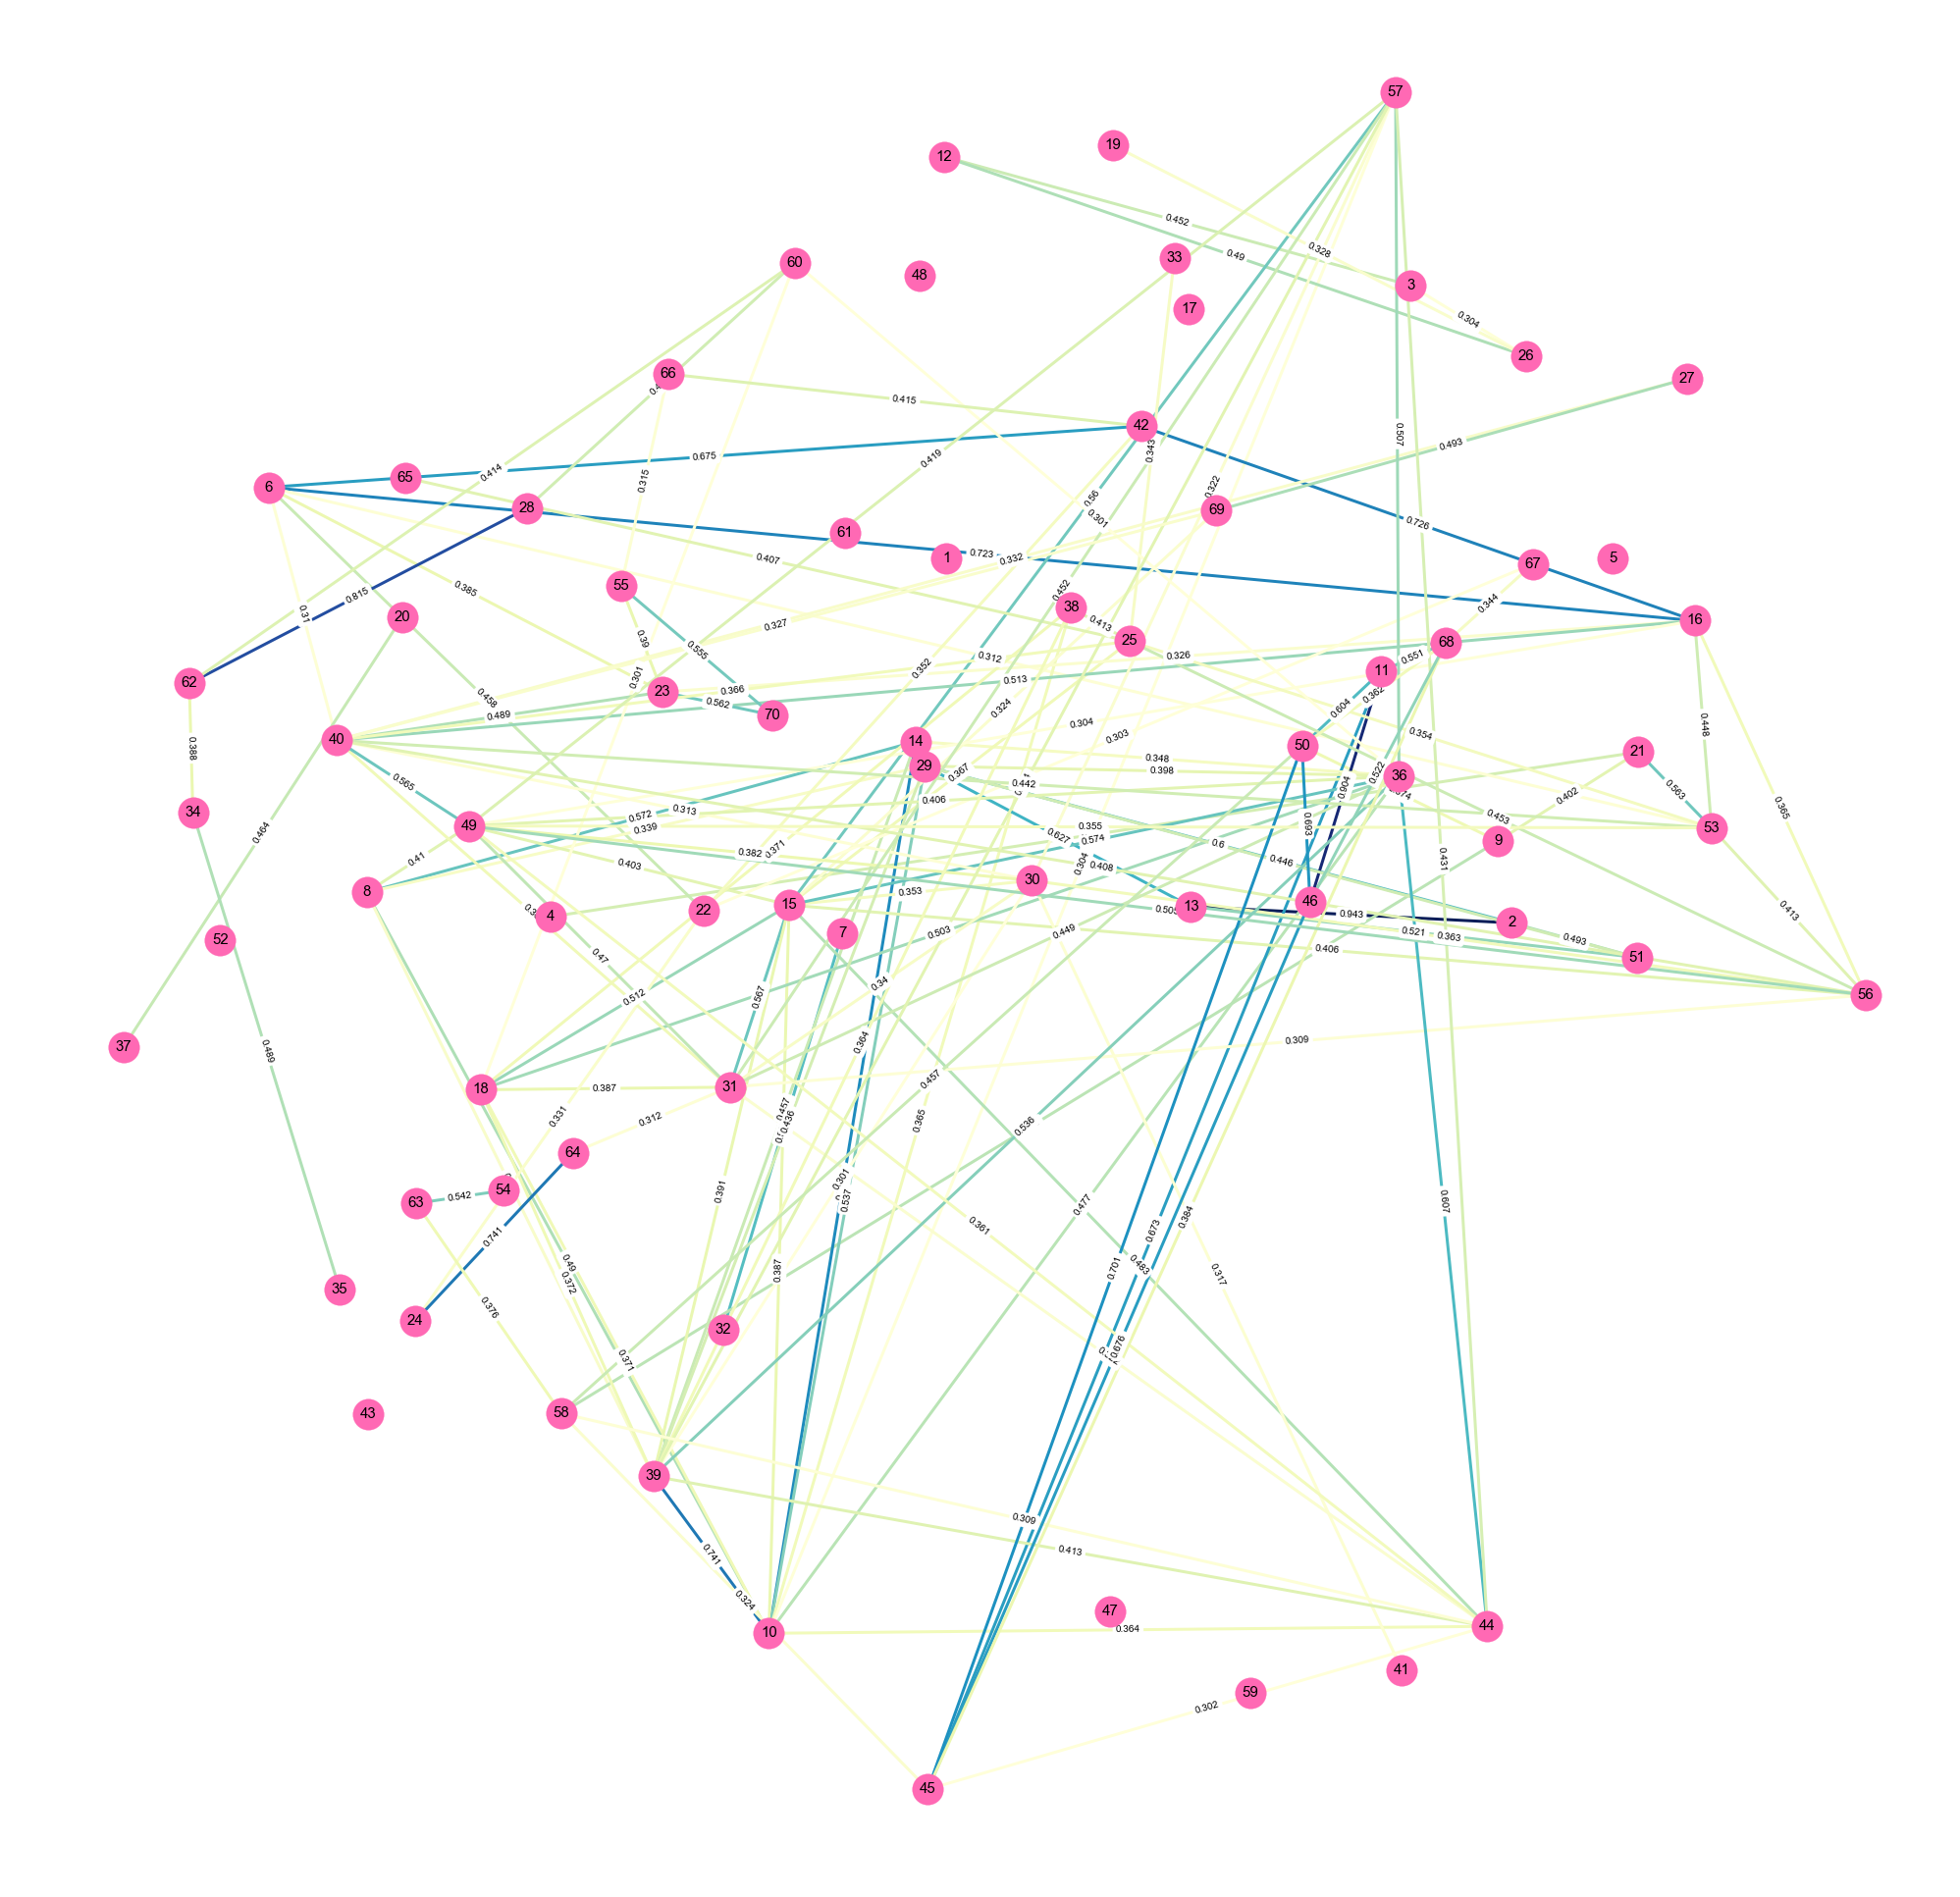

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



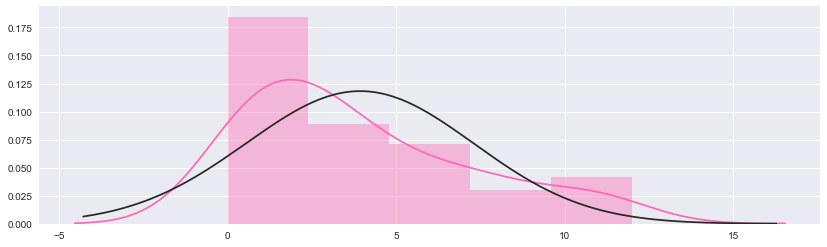

In [9]:
indices = drd87_fe.neuron_concated_behavior.loc[drd87_fe.neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
drd87_closed_arms_graph = NeuronNetwork(drd87_fe.cell_transients_df.iloc[indices])
pos = get_neuron_positions(drd87_closed_arms_graph, coordinates)

drd87_closed_arms_graph.plot(pos=pos, figsize=(35,35), node_color="hotpink", node_size=1000, save=False, file_name="drd87_closed_arms_graph.png")
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(drd87_closed_arms_graph.network.degree()).values()), color='hotpink', fit=stats.loggamma);

## Bar plot of node degree in the **Closed Arms**

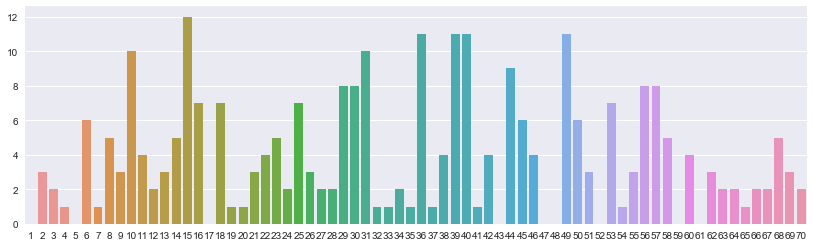

In [10]:
sns.barplot(x=list(dict(drd87_closed_arms_graph.network.degree()).keys()), y=list(dict(drd87_closed_arms_graph.network.degree()).values()));

## Plot the graph of the network while the mouse was in the closed arms. Nodes are colored is based on their betweenness centrality, from least (light-blue) to greatest (neon-purple).

In [11]:
import matplotlib.pylab as plt

def plot_by_color(graph, feature_func, **kwargs):
    feature_dict = feature_func(graph)

    plt.figure(figsize=kwargs.get("figsize", (35, 35)))

    pos = kwargs.get("pos", None)
    if pos is None:
        pos = nx.spring_layout(graph, weight="weight") 

    vmax = max(list(feature_dict.values()))
    vmin = min(list(feature_dict.values()))

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=list(feature_dict.values()), cmap=plt.cm.cool, vmax=vmax, vmin=vmin);

    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # edges
    nx.draw_networkx_edges(graph, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=15, edge_labels=labels)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm)
    plt.axis('off');
    
    save_to_file = kwargs.get("save", False)
    if save_to_file:
        title = kwargs.get("file_name", "Graph.png")
        file_format = kwargs.get("format", "PNG")
        plt.savefig(title, format=file_format)

    plt.show();

# We plot the network of drd87's neurons in the open arms. Note: nodes are colored by their corresponding degree centrality.

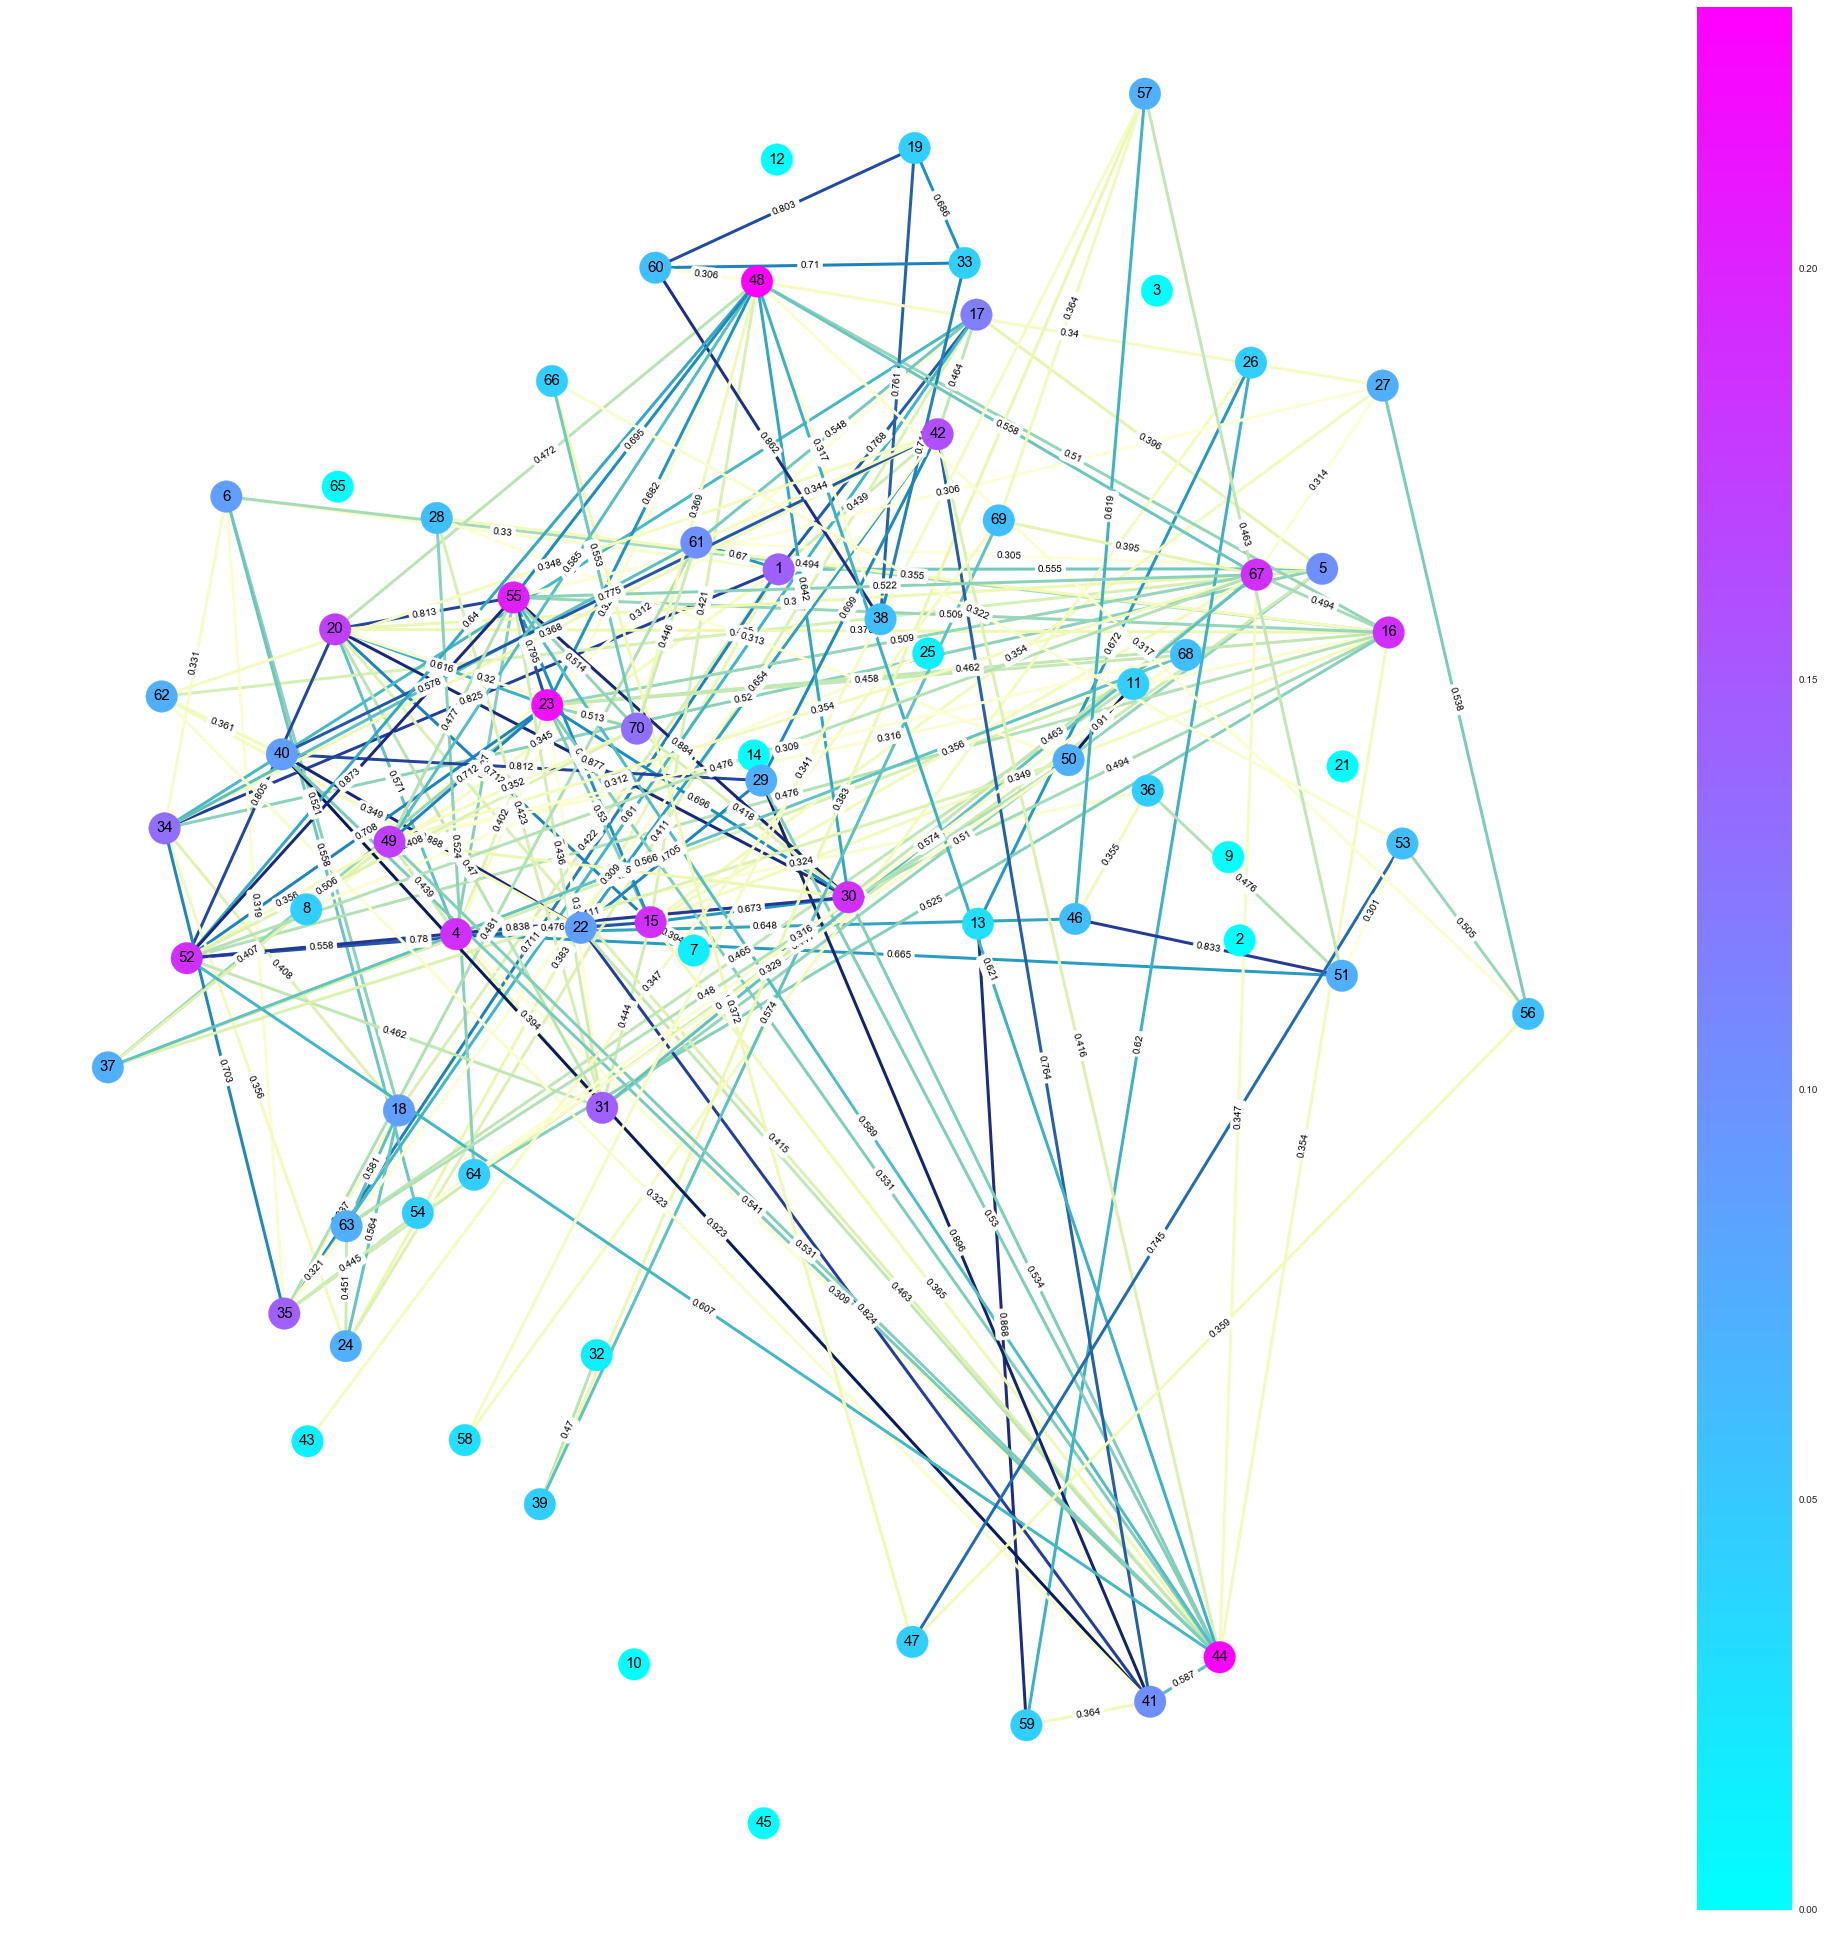

In [12]:
plot_by_color(drd87_open_arms_graph.network, nx.degree_centrality, figsize=(35, 35), pos=pos, save=True)

# We plot the network of drd87's neurons in the open arms. Note: nodes are colored by their corresponding degree centrality.

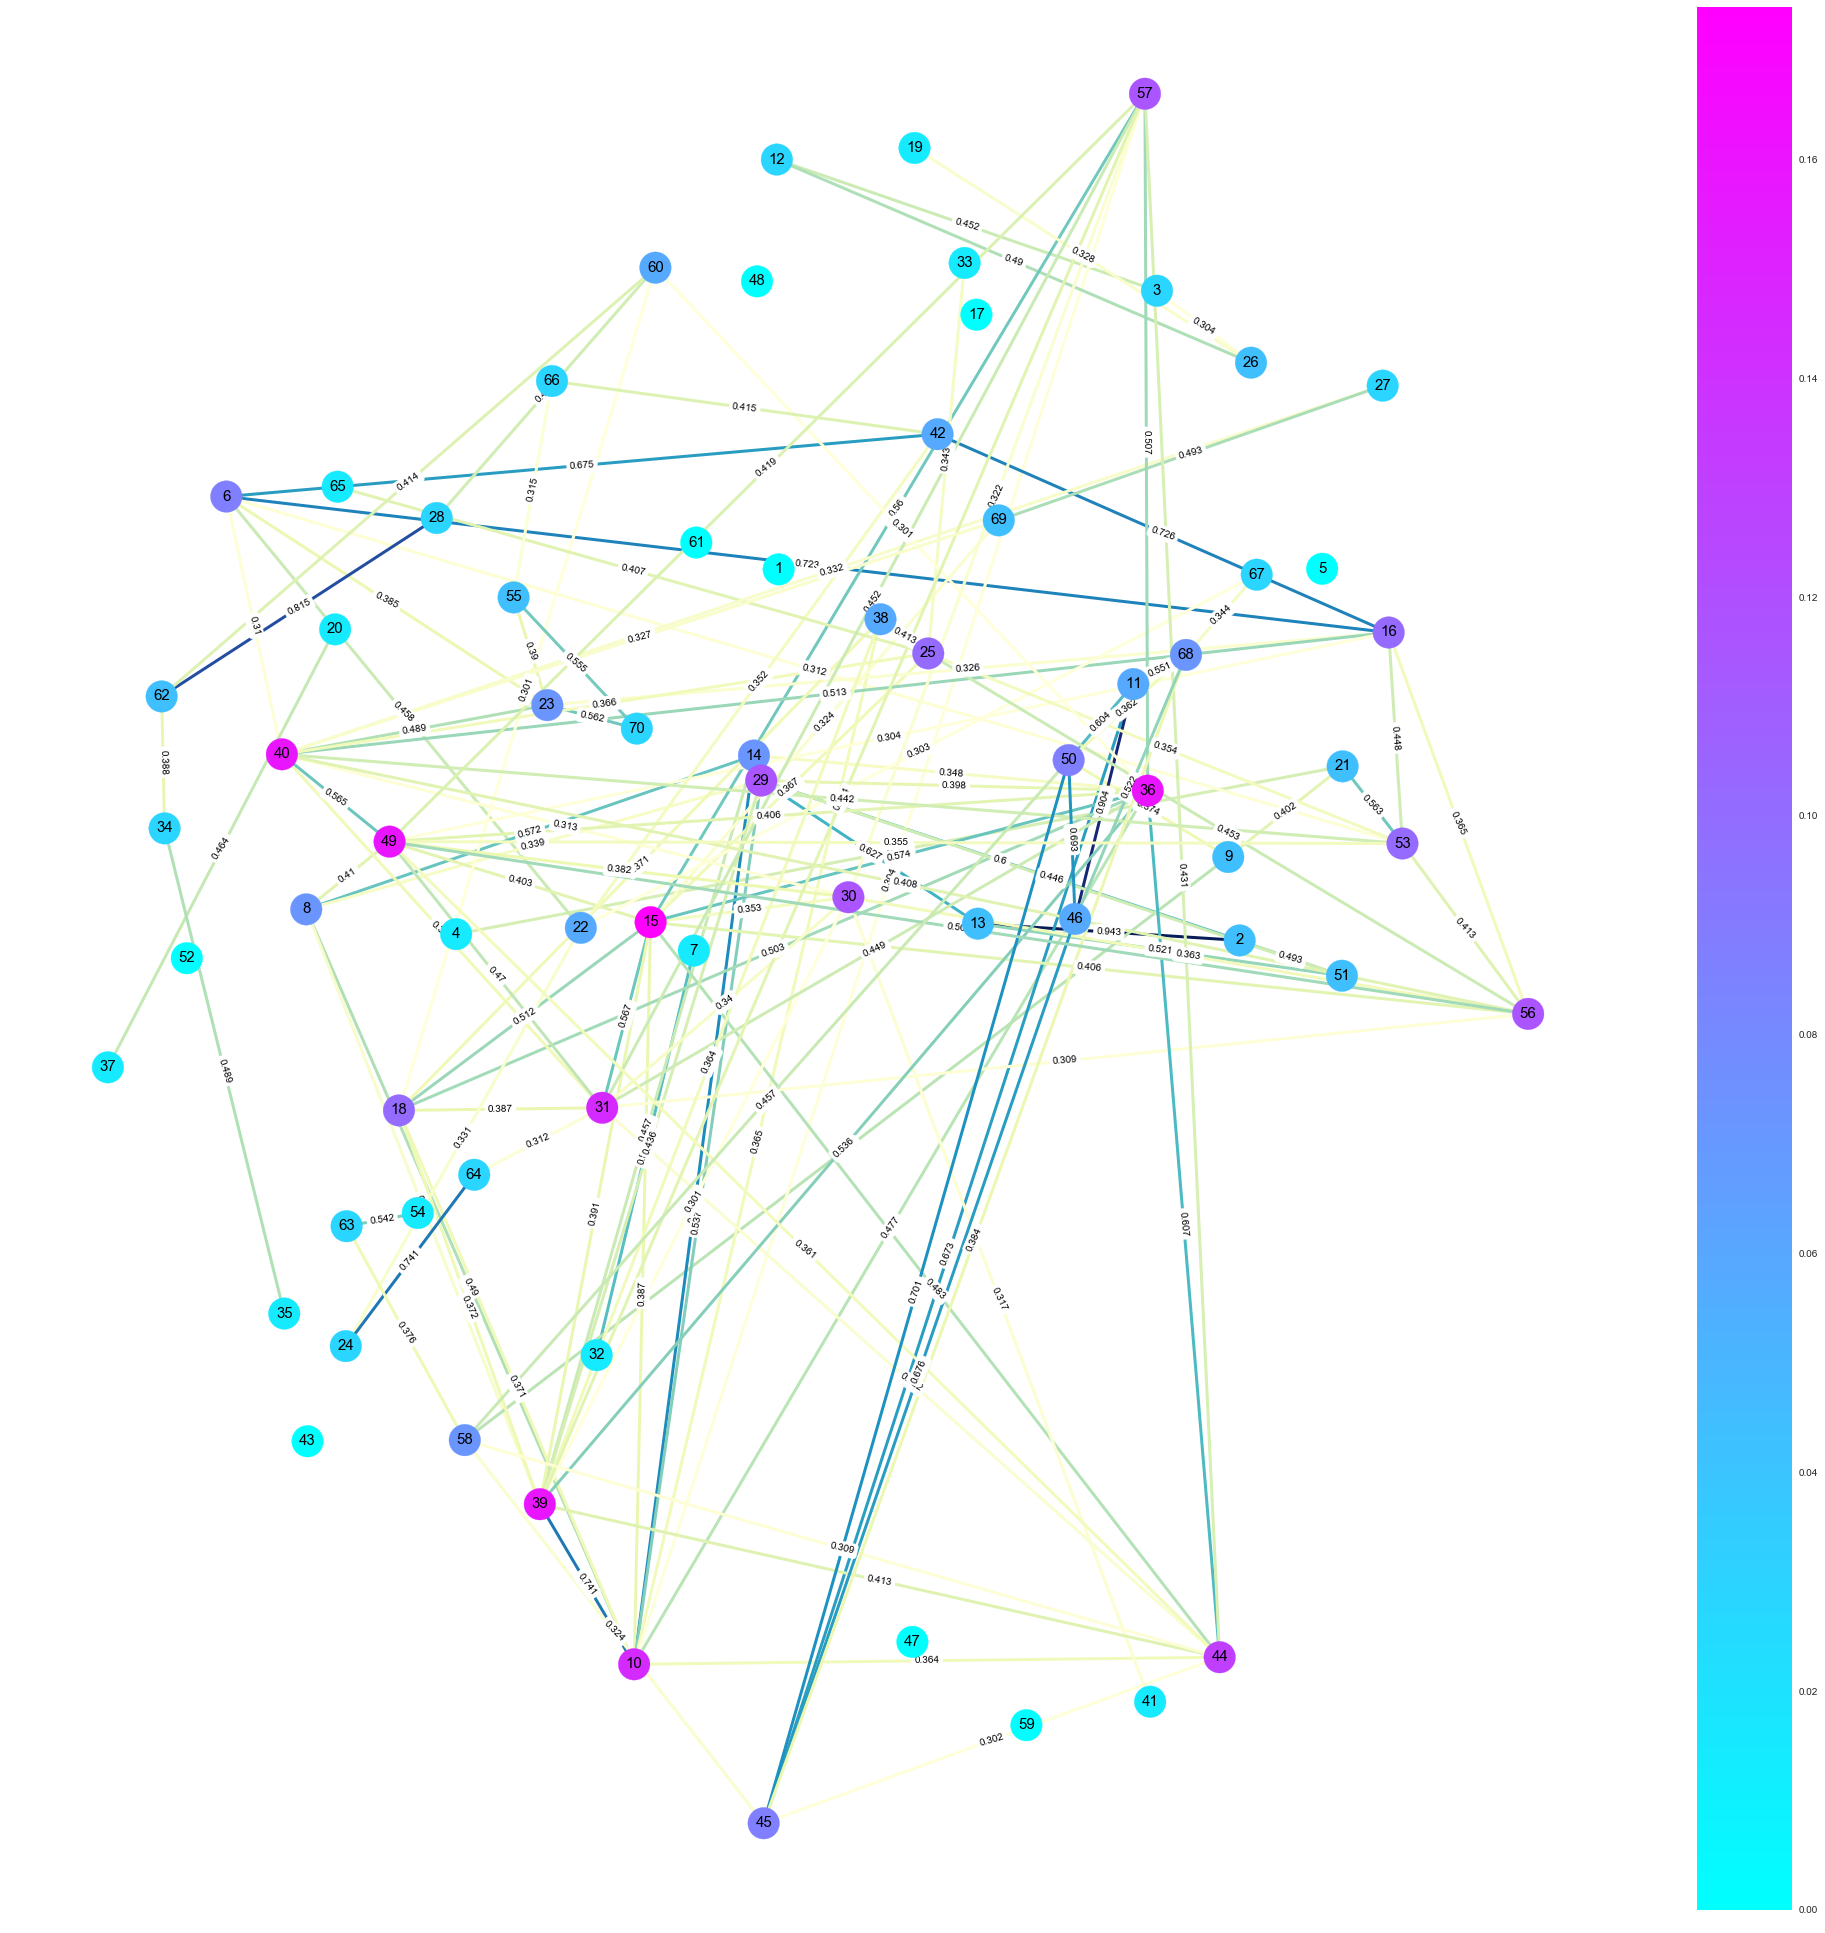

In [13]:
plot_by_color(drd87_closed_arms_graph.network, nx.degree_centrality, figsize=(35,35), pos=pos, save=True, file_name="ClosedArms_by_degree.png")

# Now we will plot the network of neurons of drd87, where each neuron is colored by it's corresponding selectivity. 

### We accomplish this as follows:
### 0. Get all the data and process it as need be

In [14]:
drd87_data = pd.read_csv(raw_files[2], header=None)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd87_data, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[0], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [15]:
drd87_real_diff_vals = drd87_fe.set_real_diff_df(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd87_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



neuron1  neuron2  neuron3  neuron4   neuron5  neuron6 neuron7 neuron8  \
D  5.72857 -3.00185 -1.36973  12.1606 -0.555661 -3.64355  8.0656 -3.7702   

    neuron9 neuron10   ...    neuron61 neuron62  neuron63  neuron64 neuron65  \
D -0.683886 -3.68069   ...     3.74837 -0.92522  0.176564  0.569157 -1.74818   

   neuron66 neuron67 neuron68 neuron69 neuron70  
D  0.711728  1.67555  1.55181  1.89085  4.47428  

[1 rows x 70 columns]

## 1. Run a permutation test to determine which neurons are selective/non-selective/unclassifiable

In [16]:
resampled_df = Resampler.shuffle(10000, drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")

## 2. Plot the distributions of all the, neuron, column vectors to see which type of statistical test is appropriate to apply.

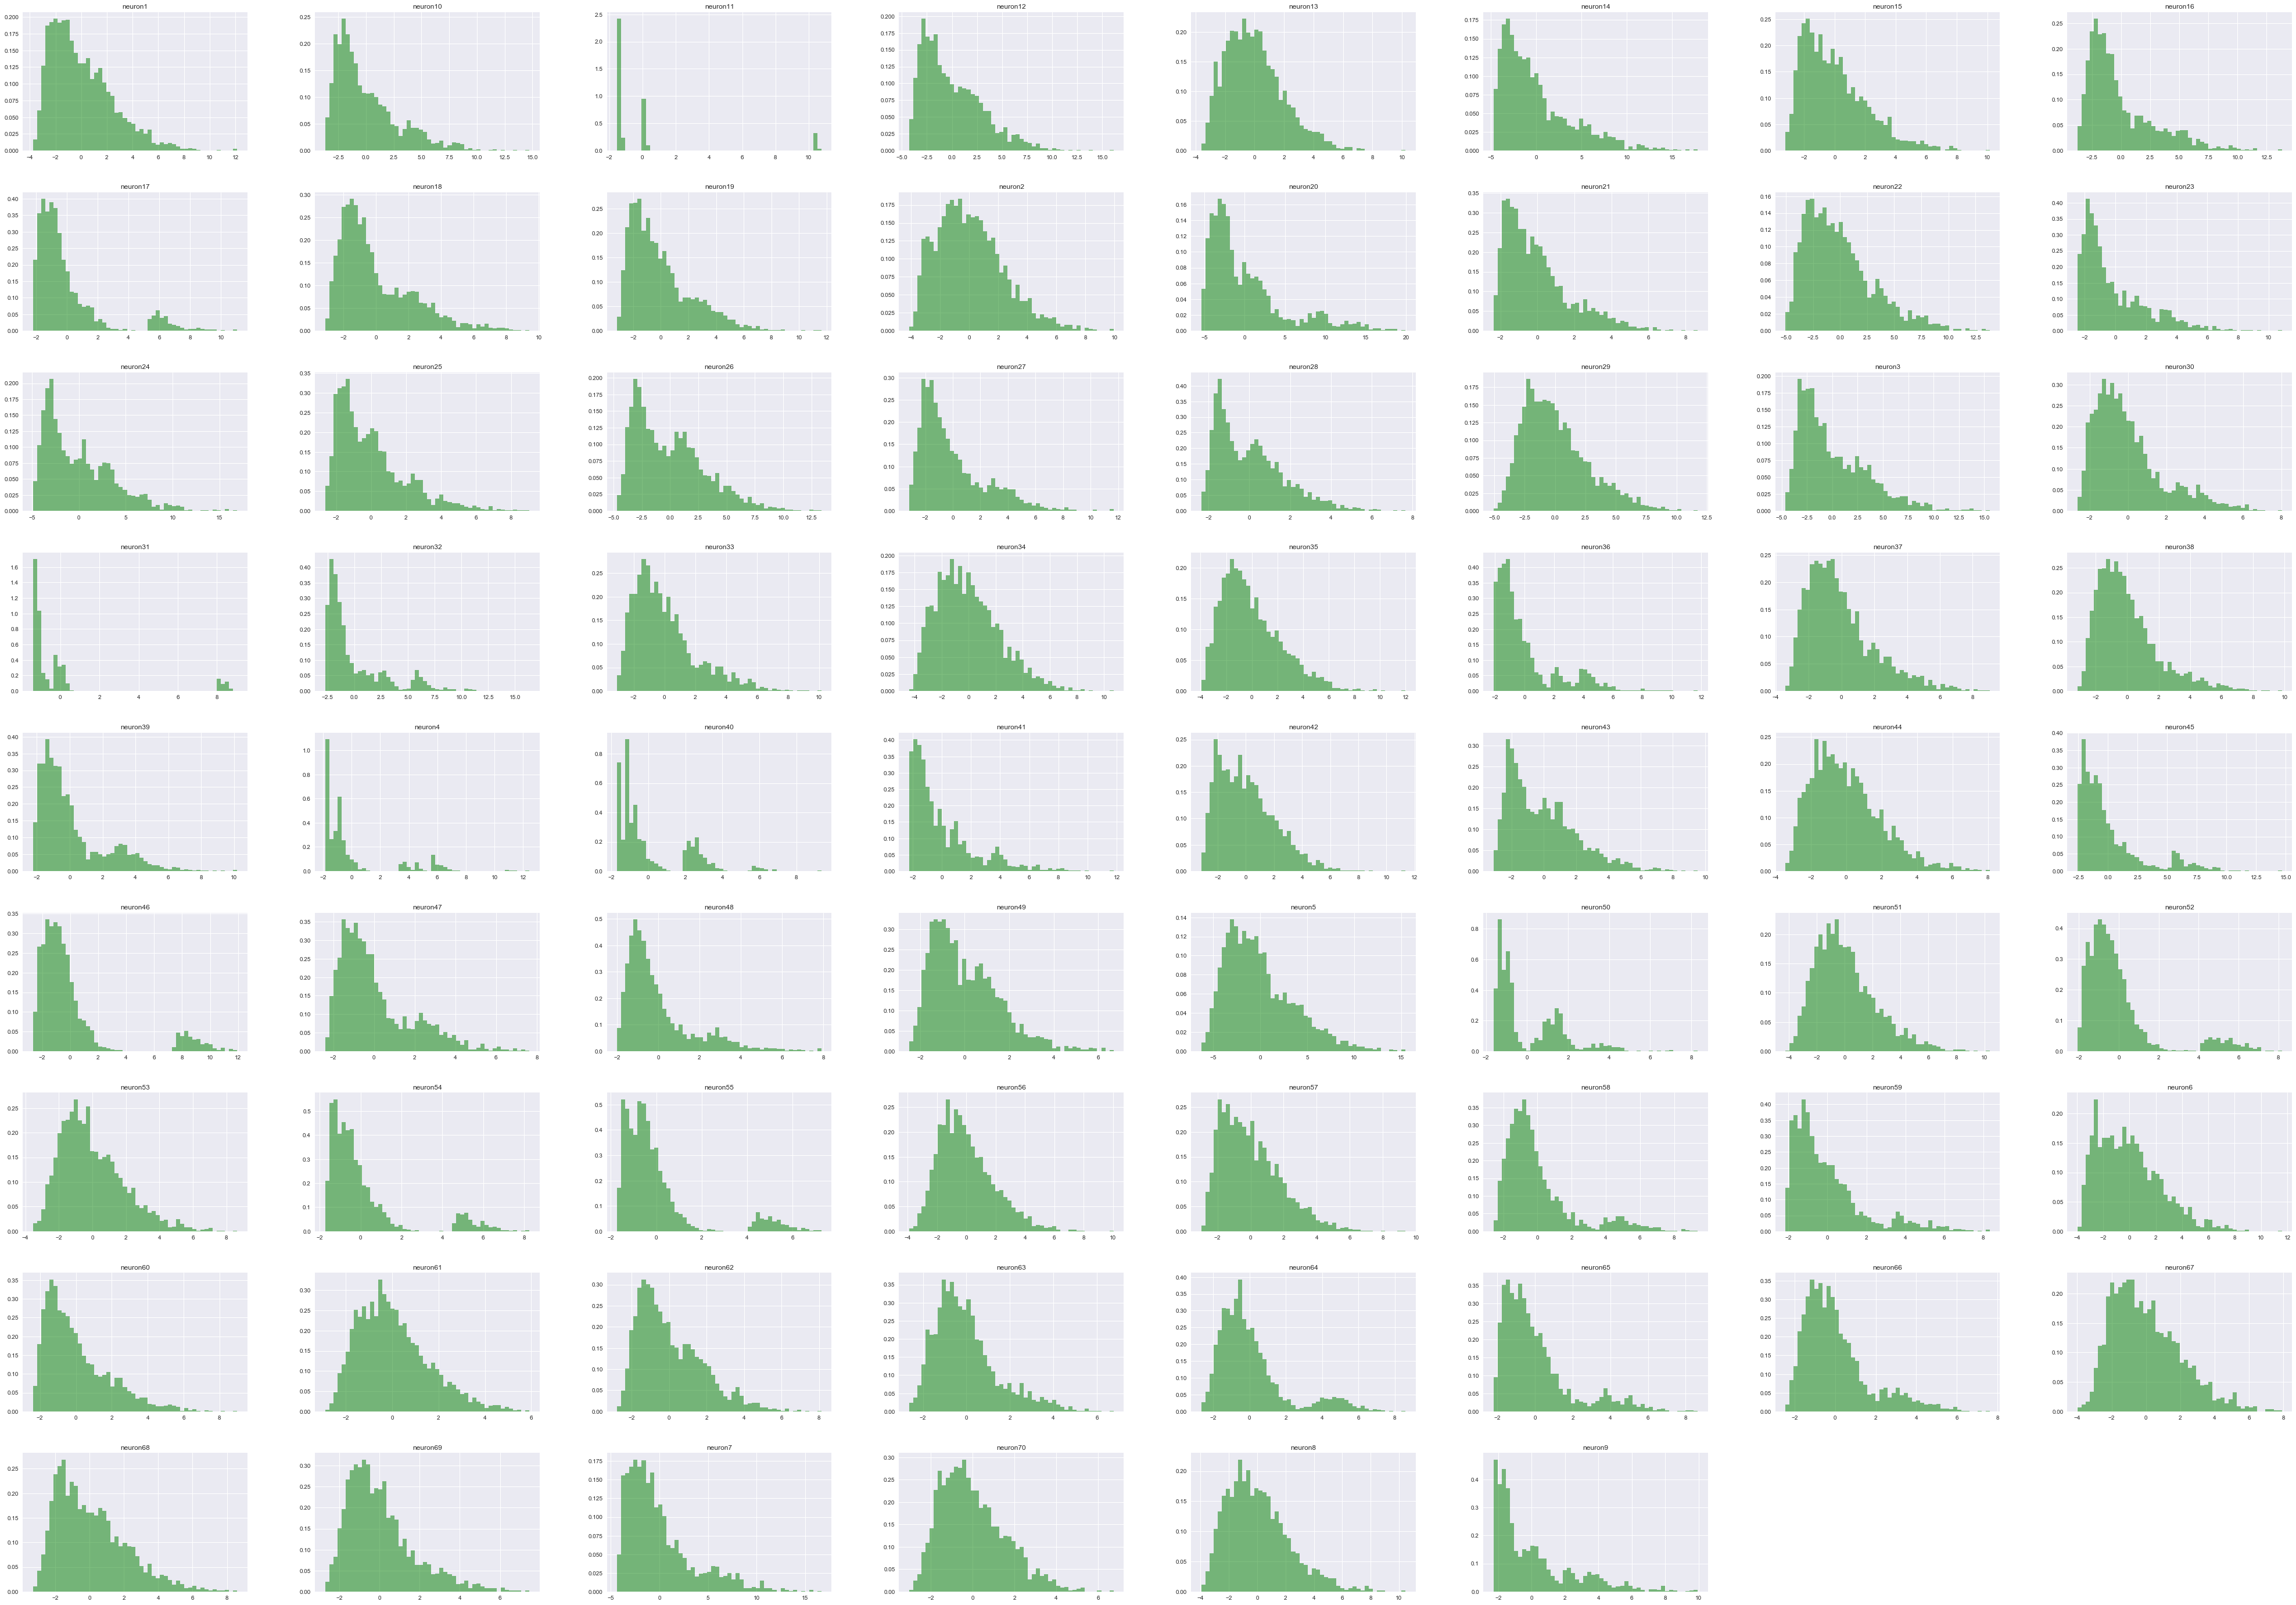

In [17]:
resampled_df.hist(alpha=0.5, color='g', density=True, figsize=(70,50), bins=50);

## 3. As we can see, the vast majority of the distributions are *not* normal. Thus, we resort to computing the two-sided $p$-value for each, neuron, column vector.

In [18]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_fe.auc_df, resampled_df, drd87_real_diff_vals, p_value=0.125, threshold=5)

## 4. Next, we utilize the *actual* difference of mean values, $\hat{D}$, in order to further classify which behavior each neuron is actually selective for, e.g. OpenArms vs. ClosedArms

In [19]:
def deep_classify(classified_neurons, real_diff_vals):
    deeper_classification = classified_neurons.copy()

    for neuron in deeper_classification:
        if real_diff_vals[neuron].values > 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = "OpenArms_centerpoint"
        elif real_diff_vals[neuron].values < 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = "ClosedArms_centerpoint"
                
    return deeper_classification

In [20]:
drd87_cell_dict = deep_classify(drd87_classified_neurons, drd87_real_diff_vals)

## 5. Now, we define a color map to apply certain colors to certain types of neuron, and we sort neurons into corresponding lists (by what they are/aren't selective for).
 - Pink: OpenArms_centerpoint
 - Light Green: ClosedArms_centerpoint
 - Light Blue: not-selective
 - Grey: unclassified

In [21]:
def sort_by_selectivity(graph, classifications):
    open_arms_nodes = list()
    closed_arms_nodes = list()
    unclassified_nodes = list()
    not_selective_nodes = list()

    for node in graph.nodes():
        if "{}{}".format("neuron", node) in classifications:
            if classifications["{}{}".format("neuron", node)] == "OpenArms_centerpoint":
                open_arms_nodes.append(node)
            elif classifications["{}{}".format("neuron", node)] == "ClosedArms_centerpoint":
                closed_arms_nodes.append(node)
            elif classifications["{}{}".format("neuron", node)] == "unclassified":
                unclassified_nodes.append(node)
            elif classifications["{}{}".format("neuron", node)] == "not-selective":
                not_selective_nodes.append(node)
                
    return open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes

In [22]:
def plot_by_selectivity(graph, *node_lists, **kwargs):
    plt.figure(figsize=kwargs.get("figsize", (35,35)))
    
    pos = kwargs.get("pos", None)
    if pos is None:
        pos = nx.spring_layout(graph, weight="weight") 
    
    node_size = kwargs.get("node_size", 1000)
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[0], node_color="pink"); 
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[1], node_color="lightgreen");
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[2], node_color="lightblue");
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[3], node_color="grey");

    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # edges
    nx.draw_networkx_edges(graph, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=15, edge_labels=labels)

    plt.axis("off");
    
    save_to_file = kwargs.get("save", False)
    if save_to_file:
        title = kwargs.get("file_name", "Graph.png")
        file_format = kwargs.get("format", "PNG")
        plt.savefig(title, format=file_format)
    
    plt.show();

## Print out all of the neurons that were classified as selective for `OpenArms`

In [23]:
for neuron in drd87_cell_dict:
    if drd87_cell_dict[neuron] == "OpenArms_centerpoint":
        print(neuron)

neuron1
neuron4
neuron7
neuron15
neuron17
neuron19
neuron21
neuron23
neuron30
neuron31
neuron32
neuron34
neuron35
neuron38
neuron39
neuron40
neuron41
neuron43
neuron47
neuron48
neuron49
neuron52
neuron55
neuron58
neuron59
neuron60
neuron61
neuron70


## First, we plot the `OpenArms` graph of DRD87, where all neurons are colored by their selectivity.

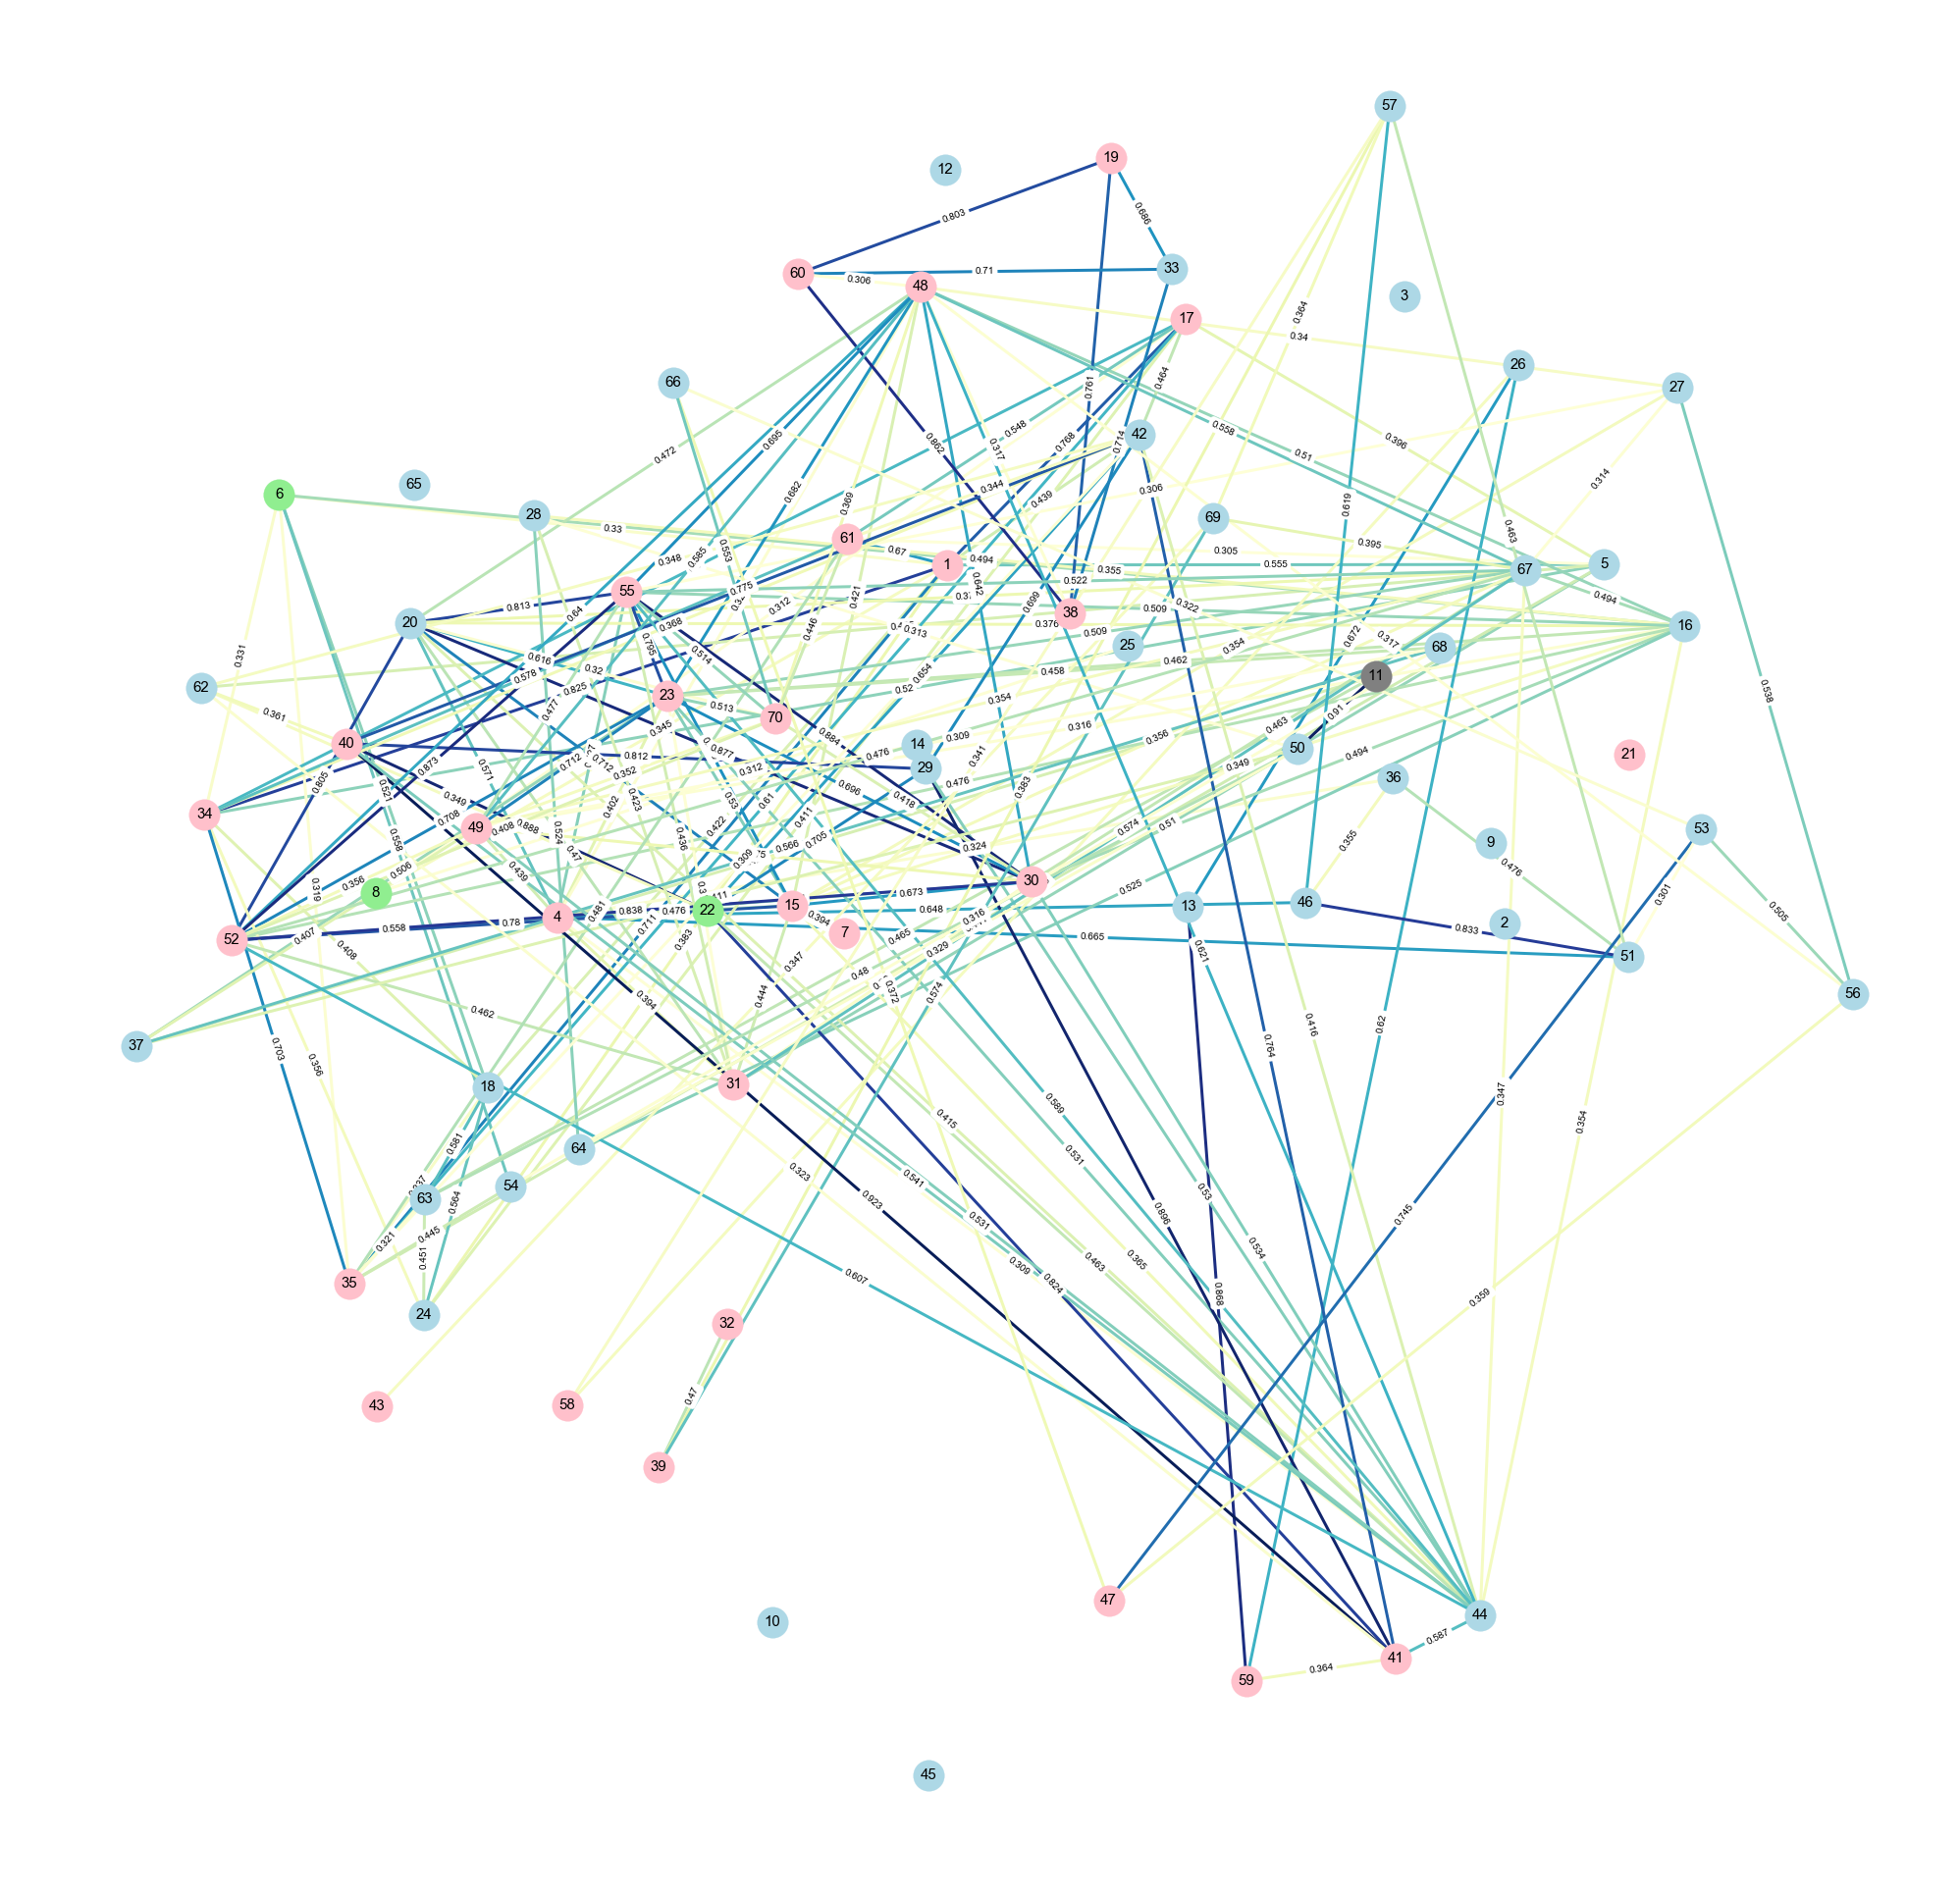

In [24]:
open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes = sort_by_selectivity(drd87_open_arms_graph.network, drd87_cell_dict)
plot_by_selectivity(drd87_open_arms_graph.network, open_arms_nodes, closed_arms_nodes, not_selective_nodes, unclassified_nodes, pos=pos, save=True, file_name="open.png")

## Now we plot the `ClosedArms` graph of DRD87, where all neurons are colored by their selectivity.

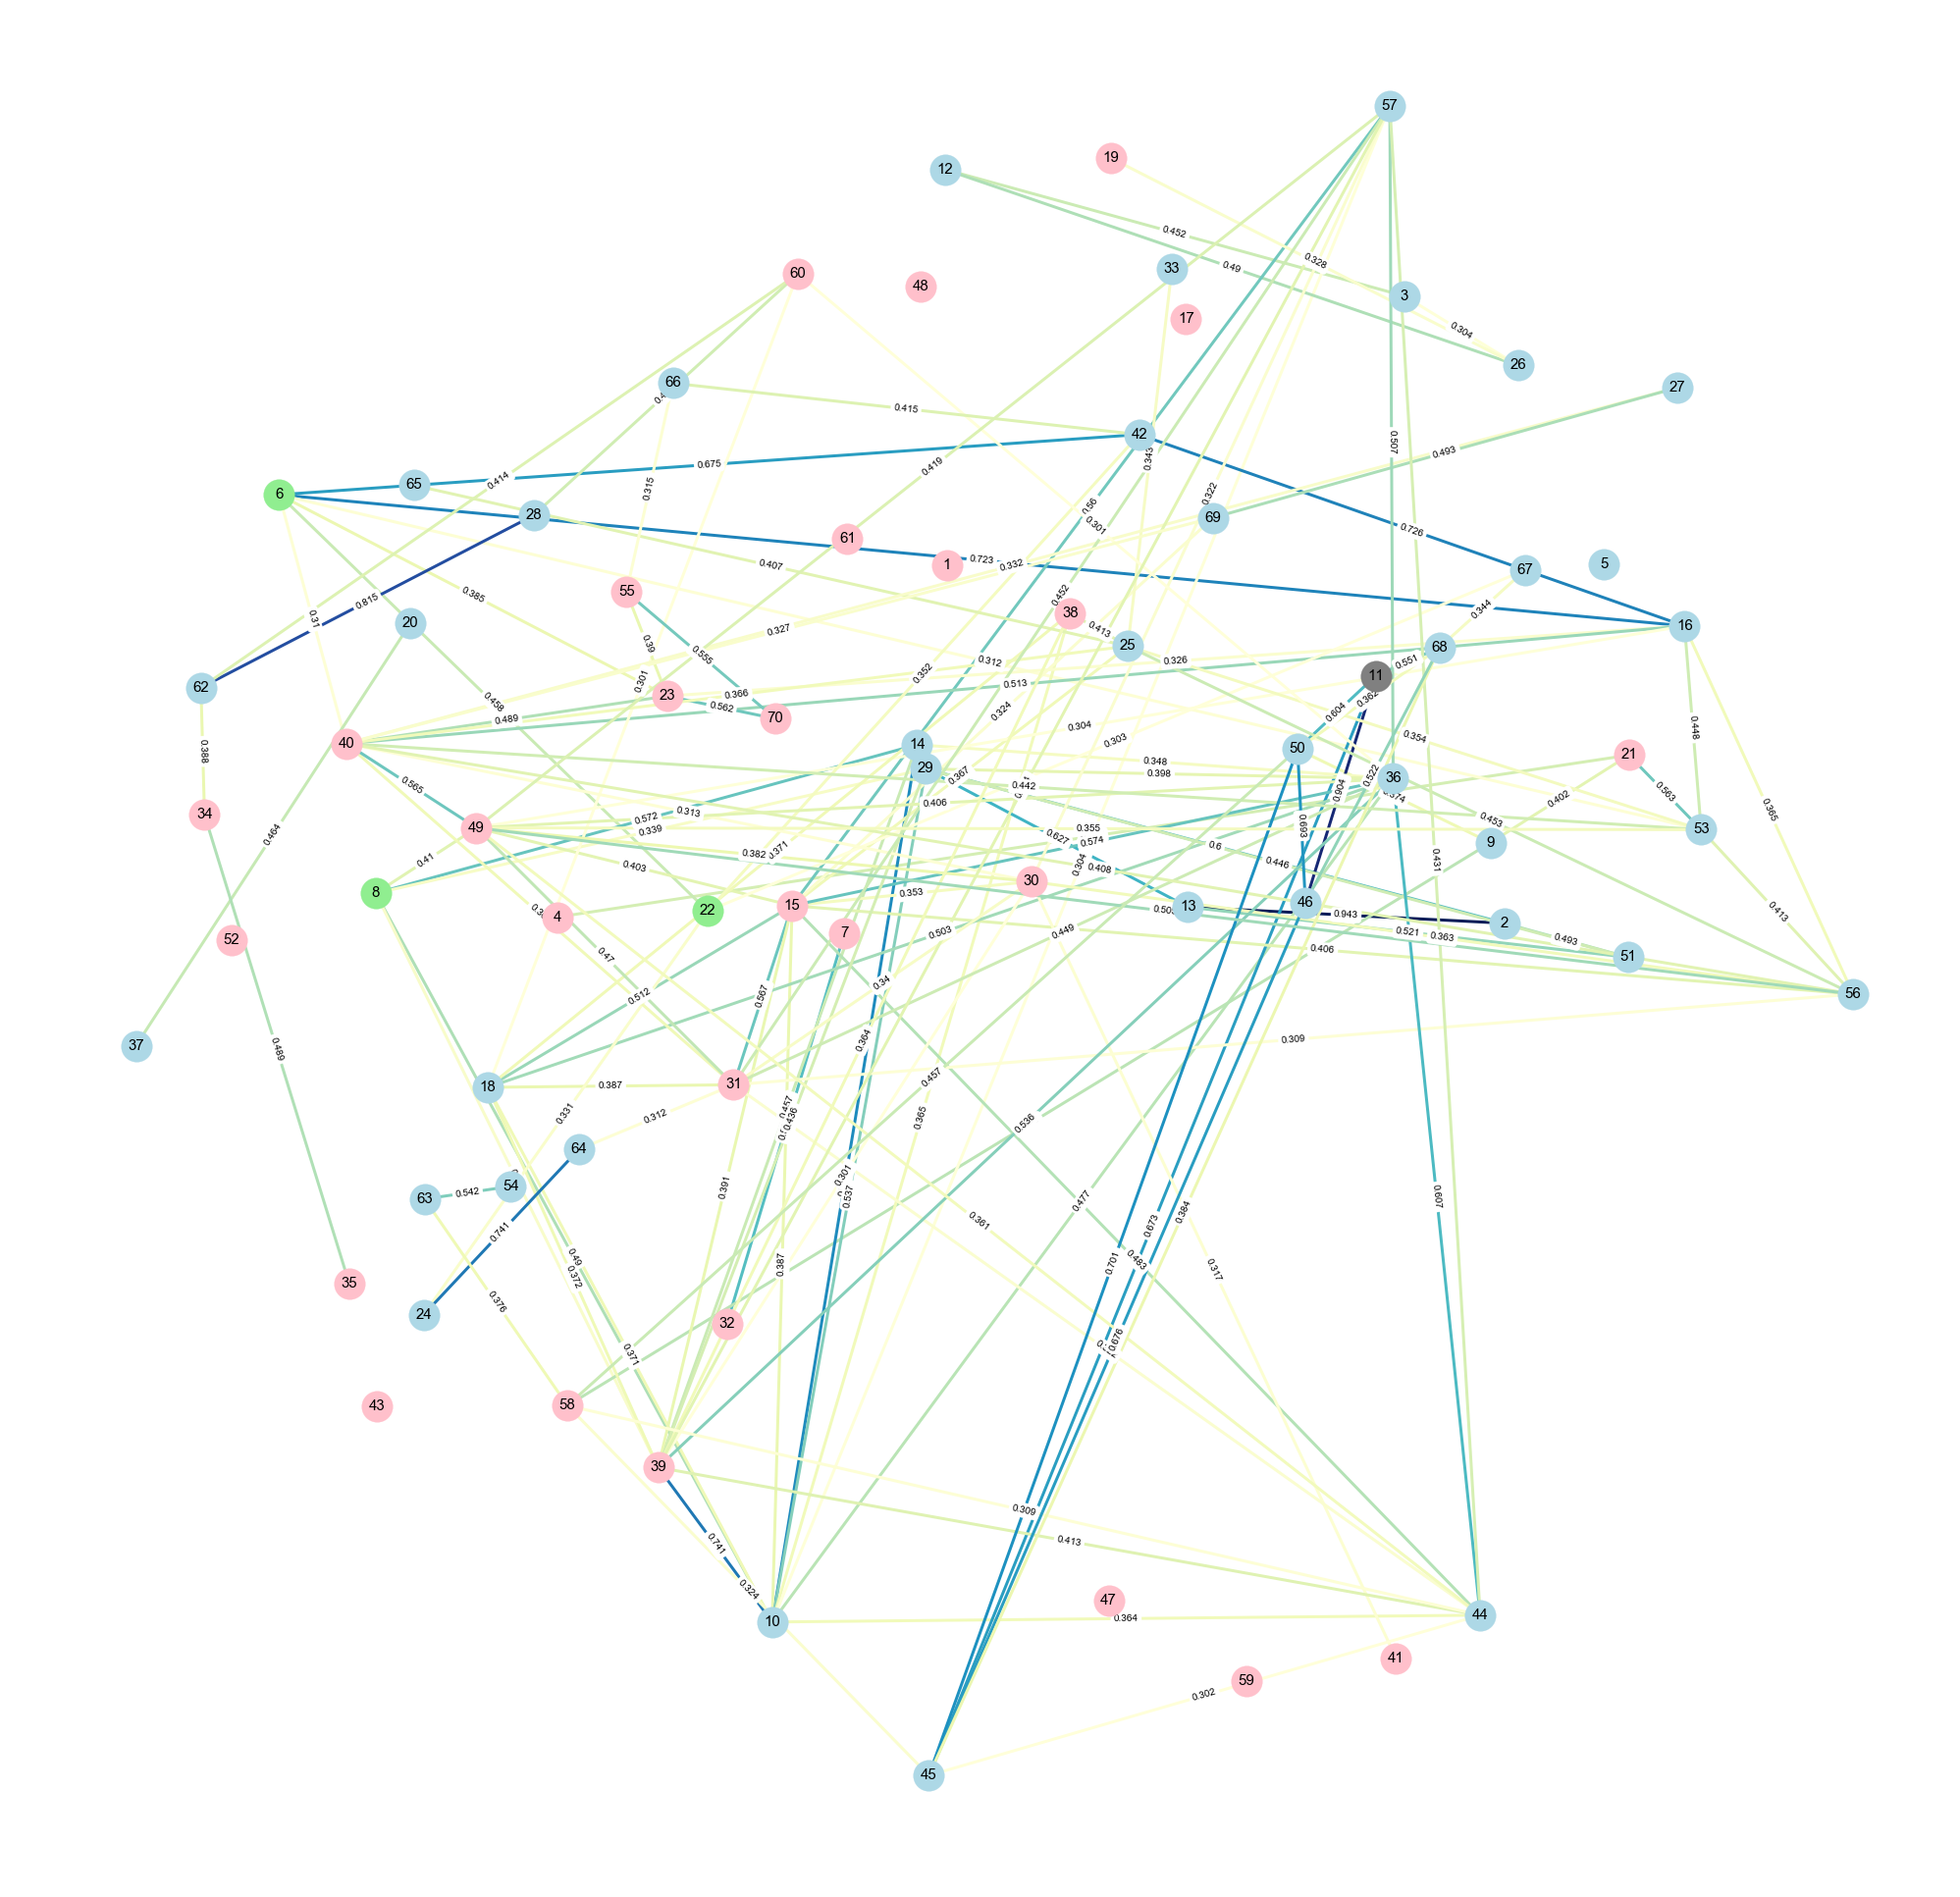

In [25]:
open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes = sort_by_selectivity(drd87_closed_arms_graph.network, drd87_cell_dict)
plot_by_selectivity(drd87_closed_arms_graph.network, open_arms_nodes, closed_arms_nodes, not_selective_nodes, unclassified_nodes, pos=pos, save=True, file_name="closed.png")